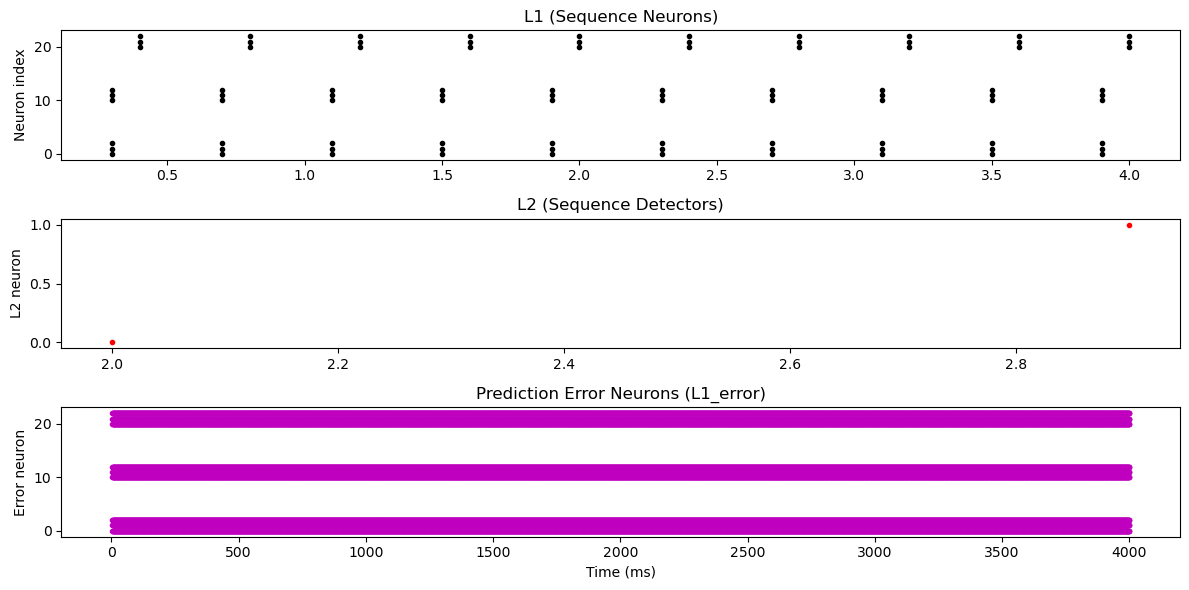

In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
start_scope()
prefs.codegen.target = "numpy"  # Run faster in pure Python
duration = 600 * ms
tau = 10*ms
v_thresh = 1.0
v_reset = 0.0
A_plus = 0.01
A_minus = -0.012
w_max = 0.05
N = 30  # Total L1 neurons
n_l2 = 2  # Number of L2 detector neurons

# === Neuron models ===
eqs = '''
dv/dt = (-v) / tau : 1
'''

error_eqs = '''
dv/dt = (I - v) / tau : 1
I : 1
'''

# === Neuron Groups ===
G = NeuronGroup(N, eqs, threshold='v>v_thresh', reset='v=0', method='exact', name='L1')
G.v = 0

L2 = NeuronGroup(n_l2, eqs, threshold='v>0.6', reset='v=0', method='exact', name='L2')
L2.v = 0

L1_error = NeuronGroup(N, error_eqs, threshold='v>1.0', reset='v=0', method='exact', name='L1_error')
L1_error.v = 0

# === Input: repeating sequence A → B → C ===
indices_A = [0, 1, 2]
indices_B = [10, 11, 12]
indices_C = [20, 21, 22]
spike_times = []

for r in range(20):
    t_base = r * 200 * ms
    spike_times += [(i, t_base) for i in indices_A]
    spike_times += [(i, t_base + 50*ms) for i in indices_B]
    spike_times += [(i, t_base + 100*ms) for i in indices_C]

spike_indices, spike_times_ms = zip(*spike_times)
spike_input = SpikeGeneratorGroup(N, spike_indices, np.array(spike_times_ms) * ms)

# === Synapses ===
# Input → L1
input_syn = Synapses(spike_input, G, on_pre='v_post += 0.6')
input_syn.connect(j='i')

# L1 recurrent (STDP)
syn = Synapses(G, G,
    '''
    w : 1
    dpre/dt = -pre / tau : 1 (event-driven)
    dpost/dt = -post / tau : 1 (event-driven)
    ''',
    on_pre='''
    v_post += w
    pre += 1.
    w = clip(w + A_plus * post, 0, w_max)
    ''',
    on_post='''
    post += 1.
    w = clip(w + A_minus * pre, 0, w_max)
    '''
)
syn.connect(p=0.1)
syn.w = 'rand() * 0.01'

# L1 → L2 (Hebbian)
L1_L2 = Synapses(G, L2,
    '''
    w : 1
    dpre/dt = -pre / tau : 1 (event-driven)
    dpost/dt = -post / tau : 1 (event-driven)
    ''',
    on_pre='''
    v_post += w
    pre += 1.
    w = clip(w + A_plus * post, 0, w_max)
    ''',
    on_post='''
    post += 1.
    w = clip(w + A_minus * pre, 0, w_max)
    '''
)
L1_L2.connect(p=0.5)
L1_L2.w = '0.05 + rand() * 0.02'

# L2 → L1 feedback (top-down prediction)
L2_L1 = Synapses(L2, G, on_pre='v_post += 0.3')
L2_L1.connect(i=0, j=[10, 11, 12])  # L2[0] predicts B group
L2_L1.connect(i=1, j=[20, 21, 22])  # L2[1] predicts C group

# L1 → L1_error (actual input)
actual_syn = Synapses(G, L1_error, on_pre='I_post += 1.0')
actual_syn.connect(j='i')

# L2 → L1_error (predicted input)
predict_syn = Synapses(L2, L1_error, on_pre='I_post -= 1.0')
predict_syn.connect(i=0, j=[10, 11, 12])  # prediction of B
predict_syn.connect(i=1, j=[20, 21, 22])  # prediction of C

# === Monitors ===
spike_mon_L1 = SpikeMonitor(G)
spike_mon_L2 = SpikeMonitor(L2)
spike_mon_err = SpikeMonitor(L1_error)

# === Build and Run ===
net = Network(collect())  # collect all defined objects
net.run(4000 * ms)

# === Plotting ===
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
plt.plot(spike_mon_L1.t/ms, spike_mon_L1.i, '.k')
plt.title('L1 (Sequence Neurons)')
plt.ylabel('Neuron index')

plt.subplot(3,1,2)
plt.plot(spike_mon_L2.t/ms, spike_mon_L2.i, '.r')
plt.title('L2 (Sequence Detectors)')
plt.ylabel('L2 neuron')

plt.subplot(3,1,3)
plt.plot(spike_mon_err.t/ms, spike_mon_err.i, '.m')
plt.title('Prediction Error Neurons (L1_error)')
plt.xlabel('Time (ms)')
plt.ylabel('Error neuron')

plt.tight_layout()
plt.show()
